In [1]:
import sys

sys.path.append("..")  # Ensure the parent directory is in the path

import core.assingment as Models
from core.DataLoader import DataPreprocessor, DataConfig
import core
import numpy as np
from importlib import reload
import keras
import matplotlib.pyplot as plt

MAX_JETS = 6

PLOTS_DIR = f"plots/"
import os

if not os.path.exists(PLOTS_DIR):
    os.makedirs(PLOTS_DIR)

config = DataConfig(
    jet_features=[
        "ordered_jet_pt",
        "ordered_jet_eta",
        "ordered_jet_phi",
        "ordered_jet_e",
        "ordered_jet_b_tag",
    ],
    lepton_features=["lep_pt", "lep_eta", "lep_phi", "lep_e"],
    jet_truth_label="ordered_event_jet_truth_idx",
    lepton_truth_label="event_lepton_truth_idx",
    met_features=["met_met_NOSYS", "met_phi_NOSYS"],
    max_leptons=2,
    max_jets=MAX_JETS,
    non_training_features=["truth_ttbar_mass", "truth_ttbar_pt", "N_jets"],
    event_weight="weight_mc_NOSYS",
)

DataProcessor = DataPreprocessor(config)
DataProcessor.load_data(
    "/data/dust/group/atlas/ttreco/full_training.root", "reco", max_events=1000000
)
X_train, y_train, X_val, y_val = DataProcessor.split_data(
    test_size=0.1, random_state=42
)

2025-10-22 13:37:28.126296: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-22 13:37:28.127109: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-22 13:37:28.130811: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-22 13:37:28.139783: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761133048.155893 3688229 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761133048.16

In [2]:
reload(Models)
reload(core)
TransformerMatcher = Models.FeatureConcatRNN(config, name="Transformer")

TransformerMatcher.build_model(
    hidden_dim=32,
    num_layers=6,
    dropout_rate=0.1,
    input_as_four_vector=True,
)

TransformerMatcher.adapt_normalization_layers(X_train)

TransformerMatcher.compile_model(
    loss = core.utils.AssignmentLoss(lambda_excl=0), optimizer=keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-4), metrics=[core.utils.AssignmentAccuracy()]
)
TransformerMatcher.model.summary()
#TransformerMatcher.load_model("Transformer_Assignment.keras")

2025-10-22 13:38:16.284798: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "FeatureConcatRNN"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ met_inputs          │ (None, 1, 2)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lep_inputs          │ (None, 2, 4)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ met_input_transform │ (None, 1, 2)      │          0 │ met_inputs[0][0]  │
│ (InputMetPhiLayer)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lep_input_transform │ (None, 2, 4)      │          0 │ lep_inputs[0][0]  │
│ (InputPtEtaPhiELay… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ jet_inputs          │ (None, 6, 5)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ met_input_normaliz… │ (None, 1, 2)      │          5 │ met_input_transf… │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lep_input_normaliz… │ (None, 2, 4)      │          9 │ lep_input_transf… │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ jet_input_transform │ (None, 6, 5)      │          0 │ jet_inputs[0][0]  │
│ (InputPtEtaPhiELay… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2)         │          0 │ met_input_normal… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 8)         │          0 │ lep_input_normal… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ jet_input_normaliz… │ (None, 6, 5)      │         11 │ jet_input_transf… │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 6, 2)      │          0 │ flatten[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_1     │ (None, 6, 8)      │          0 │ flatten_1[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 6, 15)     │          0 │ jet_input_normal… │
│ (Concatenate)       │                   │            │ repeat_vector[0]… │
│                     │                   │            │ repeat_vector_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ jet_embedding (MLP) │ (None, 6, 32)     │      1,584 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ jet_mask            │ (None, 6, 1)      │          0 │ jet_inputs[0][0]  │
│ (GenerateMask)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 6, 64)     │     16,640 │ jet_embedding[0]… │
│ (Bidirectional)     │                   │            │ jet_mask[0][0]    │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 144,617 (564.92 KB)

 Trainable params: 144,592 (564.81 KB)

 Non-trainable params: 25 (112.00 B)

In [3]:
TransformerMatcher.train_model(epochs=50,
                                X_train=X_train,
                                y_train=y_train,
                                sample_weights=core.utils.compute_sample_weights(X_train, y_train),
                                batch_size=1028,
                                callbacks = keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True, mode ="min"))

Epoch 1/50


2025-10-22 13:38:37.367858: E tensorflow/core/util/util.cc:131] oneDNN supports DT_BOOL only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


699/699 ━━━━━━━━━━━━━━━━━━━━ 185s 238ms/step - assignment_accuracy: 0.0927 - loss: 0.6554 - val_assignment_accuracy: 0.0342 - val_loss: 0.5978
Epoch 2/50
699/699 ━━━━━━━━━━━━━━━━━━━━ 194s 228ms/step - assignment_accuracy: 0.0567 - loss: 0.5769 - val_assignment_accuracy: 0.0769 - val_loss: 0.4707
Epoch 3/50
699/699 ━━━━━━━━━━━━━━━━━━━━ 163s 233ms/step - assignment_accuracy: 0.0766 - loss: 0.4911 - val_assignment_accuracy: 0.0839 - val_loss: 0.4623
Epoch 4/50
699/699 ━━━━━━━━━━━━━━━━━━━━ 201s 232ms/step - assignment_accuracy: 0.0979 - loss: 0.4742 - val_assignment_accuracy: 0.2460 - val_loss: 0.4597
Epoch 5/50
699/699 ━━━━━━━━━━━━━━━━━━━━ 196s 223ms/step - assignment_accuracy: 0.1379 - loss: 0.4708 - val_assignment_accuracy: 0.3096 - val_loss: 0.4578
Epoch 6/50
699/699 ━━━━━━━━━━━━━━━━━━━━ 209s 233ms/step - assignment_accuracy: 0.2324 - loss: 0.4675 - val_assignment_accuracy: 0.4084 - val_loss: 0.4532
Epoch 7/50
699/699 ━━━━━━━━━━━━━━━━━━━━ 208s 242ms/step - assignment_accuracy: 0.3753 -

In [4]:
TransformerMatcher.save_model("RNN_Assignment.keras")

In [5]:
pred_val = TransformerMatcher.predict_indices(X_val)

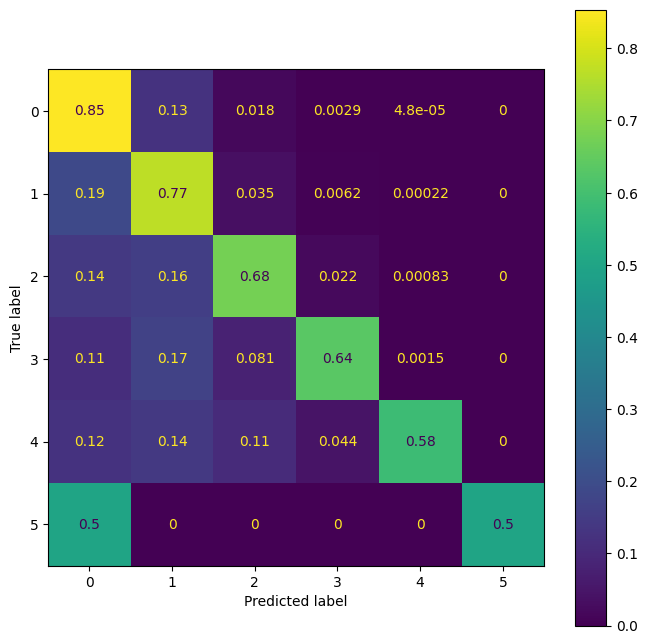

In [6]:
from sklearn.metrics import ConfusionMatrixDisplay
fig, ax = plt.subplots(figsize=(8,8))
ConfusionMatrixDisplay.from_predictions(y_val[:,:,1].argmax(axis=-1),pred_val[:,:,1].argmax(axis=-1), normalize="true", ax=ax)
plt.savefig(PLOTS_DIR+"/RNN_confusion_matrix_lepton.png")

In [7]:
reload(core)
ml_eval = core.assingment.MLEvaluatorBase(TransformerMatcher, X_val, y_val)

Baseline Performance: 0.7707


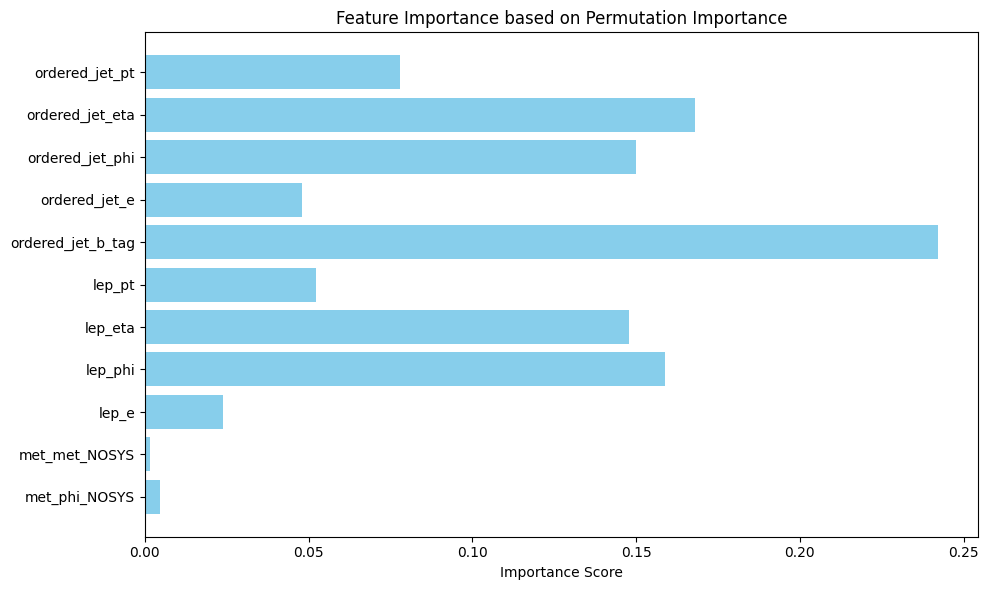

In [8]:
ml_eval.plot_feature_importance(num_repeats=1)

In [9]:
TransformerMatcher.export_to_onnx("RNN_Assignment.onnx")

I0000 00:00:1761143212.453591 3688229 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00:1761143212.454196 3688229 single_machine.cc:374] Starting new session
I0000 00:00:1761143212.808531 3688229 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00:1761143212.808715 3688229 single_machine.cc:374] Starting new session
TF freezing failed. Attempting to fix freezing errors.
Removed ConcatV2 functional_1/FeatureConcatRNN_1/bidirectional_5_1/backward_bidirectional_rnn_5_1/AssignVariableOp
Removed FloorMod functional_1/FeatureConcatRNN_1/bidirectional_5_1/forward_bidirectional_rnn_5_1/AssignVariableOp
Removed FloorMod functional_1/FeatureConcatRNN_1/bidirectional_4_1/backward_bidirectional_rnn_4_1/AssignVariableOp
Removed FloorMod functional_1/FeatureConcatRNN_1/bidirectional_4_1/forward_bidirectional_rnn_4_1/AssignVariableOp
Removed FloorMod functional_1/FeatureConcatRNN_1/bidirectional_3_1/backwa

ONNX model saved to RNN_Assignment.onnx


In [10]:
import onnx
import onnxruntime as ort
onnx_model = onnx.load("RNN_Assignment.onnx")
onnx.checker.check_model(onnx_model)
ort_session = ort.InferenceSession("RNN_Assignment.onnx")
flatted_inputs = np.concatenate([X_val['jet'].reshape(X_val['jet'].shape[0], -1), X_val['lepton'].reshape(X_val['lepton'].shape[0], -1), X_val['global'].reshape(X_val["global"].shape[0],-1)], axis=-1).astype(np.float32)

KeyError: 'global'

In [ ]:
outputs = ort_session.run(None, {"flat_input": flatted_inputs})[0]

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_val[:,:,0].argmax(axis=-1),outputs[:,:,0].argmax(axis=-1), normalize="true")


In [ ]:
import onnx

model = onnx.load("RNN_Assignment.onnx")
print([inp.name for inp in model.graph.input])
print([out.name for out in model.graph.output])

In [ ]:
import core.assingment.BaselineMethods as BaselineMethods
import core.assingment.Evaluation as Evaluation
reload(Evaluation)
reload(BaselineMethods)
delta_r_assigner = BaselineMethods.DeltaRAssigner(config, name=r"$\Delta R$-Assignment")
invariant_mass_assigner = BaselineMethods.LeptonJetMassAssigner(config, name = r"$m(\ell, j)$-Assignment")

evaluator = Evaluation.JetAssignmentEvaluator([delta_r_assigner,invariant_mass_assigner,TransformerMatcher], X_val, y_val)

In [ ]:
evaluator.plot_binned_accuracy(feature_data_type='non_training', feature_name='truth_ttbar_mass', xlims = (340e3,800e3))

In [ ]:
evaluator.plot_confusion_matrices()